In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Add
from tensorflow.keras.optimizers import Adam


In [ ]:
# paths
NC_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/Concatenated_Wave_Data_Bay_of_Bengal.nc"
CENTROID_CSV = "/content/drive/MyDrive/Wave_Monthly_Plots/centroids_upper_25.csv"

# dataset variable names
wave_var = "swh"
time_dim = "valid_time"
lat_dim = "latitude"
lon_dim = "longitude"

# training params
BATCH_SIZE = 8
EPOCHS = 30


In [ ]:
ds = xr.open_dataset(NC_PATH)
print(ds)


<xarray.Dataset> Size: 4GB
Dimensions:     (valid_time: 350640, latitude: 21, longitude: 33)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3MB 1984-11-01 ... 2024-10-31T23:...
  * latitude    (latitude) float64 168B 23.0 22.5 22.0 21.5 ... 14.0 13.5 13.0
  * longitude   (longitude) float64 264B 79.0 79.5 80.0 80.5 ... 94.0 94.5 95.0
    number      int64 8B ...
    expver      (valid_time) <U4 6MB ...
Data variables:
    mwd         (valid_time, latitude, longitude) float32 972MB ...
    swh         (valid_time, latitude, longitude) float32 972MB ...
    pp1d        (valid_time, latitude, longitude) float32 972MB ...
    wdw         (valid_time, latitude, longitude) float32 972MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:           

In [ ]:
!ls /content/drive/MyDrive


 039f028d-065f-4263-a8cd-85d4880eb82e_copy.pdf
 22a0a110-86dc-4710-9c08-d723db34c1b3_copy.pdf
'abhi na jao chhod kar- final.mp3'
'Anuja CV_20250414_131636_0000.pdf'
'Anuja CV_20250522_125609_0000.pdf'
 Anuja_PostBoat.png
'Case Study A Situation in an Electric Scooter Company .pdf'
 Classroom
 Club_Duelz_BrainStroming.pdf
'club duelz.pdf'
 ClubDuelz_UXResearch_Final.docx
'Colab Notebooks'
'DOC-20250423-WA0014. (1).pdf'
 DOC-20250423-WA0014..pdf
'Document from Anuja Mukherjee.pdf'
'IMG-20231225-WA0024 (1).jpg'
'IMG-20231225-WA0024 (2).jpg'
 IMG-20231225-WA0024.jpg
 love.png
'Research Intern Application- CSIR NIO.pdf'
'Resume (1).pdf'
'Resume- Anuja Mukherjee.pdf'
 Screenshot_2025-07-28-13-25-53-24_ee7aaac10bb1eef84cdd4a30f869afeb.jpg
'Untitled document.gdoc'
'Volunteer Pics Edited'
'wave height'


In [ ]:
time = ds[time_dim].values
lat = ds[lat_dim].values
lon = ds[lon_dim].values

print("Total hours:", len(time))


Total hours: 350640


In [ ]:
lat_idx = np.where(lat >= 17.0)[0]

H = len(lat_idx)
W = len(lon)

print("Upper grid shape:", H, W)


Upper grid shape: 13 33


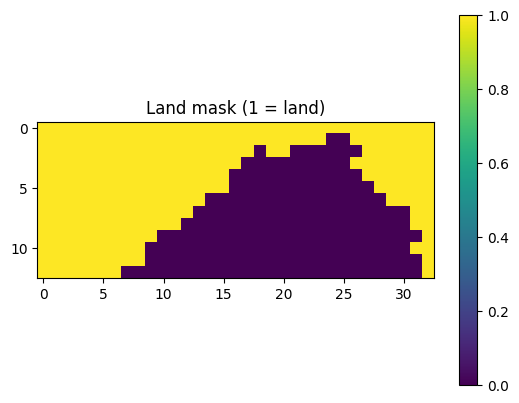

In [ ]:
sample_field = ds[wave_var].isel({time_dim: 0}).values

land_mask_full = np.isnan(sample_field) | (sample_field == 0)
land_mask = land_mask_full[lat_idx, :].astype(np.float32)

plt.imshow(land_mask)
plt.title("Land mask (1 = land)")
plt.colorbar()
plt.show()


In [ ]:
centroid_df = pd.read_csv(CENTROID_CSV)

centroid_indices = []
for _, row in centroid_df.iterrows():
    i = np.where(lat == row["grid_lat"])[0][0]
    j = np.where(lon == row["grid_lon"])[0][0]
    centroid_indices.append((i, j))

print("Number of centroids:", len(centroid_indices))


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Wave_Monthly_Plots/centroids_upper_25.csv'

In [ ]:
!find /content/drive/MyDrive -name "*centroid*.csv"


/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv


In [ ]:
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"


In [ ]:
!ls "$CENTROID_CSV"


'/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv'


In [ ]:
import pandas as pd

centroid_df = pd.read_csv(CENTROID_CSV)
print(centroid_df.head())
print(centroid_df.columns)


   centroid_lon  centroid_lat  cluster_id
0        89.125       21.3125           0
1        85.500       19.4000           1
2        92.750       18.1875           2
3        84.250       17.2500           3
4        87.900       19.1000           4
Index(['centroid_lon', 'centroid_lat', 'cluster_id'], dtype='object')


In [ ]:
centroid_indices = []

for _, row in centroid_df.iterrows():
    # find nearest latitude index
    i = np.argmin(np.abs(lat - row["centroid_lat"]))

    # find nearest longitude index
    j = np.argmin(np.abs(lon - row["centroid_lon"]))

    centroid_indices.append((i, j))

print("Number of centroids:", len(centroid_indices))


Number of centroids: 25


In [ ]:
lat_idx = np.where(lat >= 17.0)[0]

H = len(lat_idx)
W = len(lon)

print("Upper-half grid shape:", H, W)


Upper-half grid shape: 13 33


In [ ]:
def data_generator(indices, batch_size=8):
    while True:
        np.random.shuffle(indices)

        for start in range(0, len(indices), batch_size):
            batch_idx = indices[start:start + batch_size]

            X_batch, y_batch = [], []

            for t in batch_idx:
                field = ds[wave_var].isel({time_dim: t}).values

                # TARGET: full upper-half wave field
                y_t = field[lat_idx, :].copy()
                y_t[np.isnan(y_t)] = 0

                # INPUT: sparse centroids only
                X_t = np.zeros((H, W), dtype=np.float32)

                for (i, j) in centroid_indices:
                    i_upper = np.where(lat_idx == i)[0][0]
                    X_t[i_upper, j] = field[i, j]

                # force land to zero
                X_t[land_mask == 1] = 0

                X_batch.append(X_t)
                y_batch.append(y_t)

            yield (
                np.array(X_batch)[..., np.newaxis],
                np.array(y_batch)[..., np.newaxis]
            )


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Add
from tensorflow.keras.models import Model

def build_cnn(H, W):
    inp = Input(shape=(H, W, 1))

    x1 = Conv2D(64, 3, padding="same", activation="relu")(inp)
    x1 = Conv2D(64, 3, padding="same", activation="relu")(x1)

    x2 = Conv2D(64, 3, dilation_rate=2, padding="same", activation="relu")(x1)
    x2 = Conv2D(64, 3, dilation_rate=2, padding="same", activation="relu")(x2)

    x3 = Conv2D(64, 3, dilation_rate=4, padding="same", activation="relu")(x2)
    x3 = Conv2D(64, 3, dilation_rate=4, padding="same", activation="relu")(x3)

    x = Add()([x1, x2, x3])

    x = Conv2D(64, 3, padding="same", activation="relu")(x)
    x = Conv2D(32, 3, padding="same", activation="relu")(x)

    out = Conv2D(1, 1, activation="linear")(x)

    return Model(inp, out)


In [ ]:
from tensorflow.keras.optimizers import Adam

model = build_cnn(H, W)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="mse"
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 33, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 13, 33,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 13, 33,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 33,    │     36,928 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 13, 33,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 13, 33,    │     36,928 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 13, 33,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 13, 33,    │          0 │ conv2d_1[0][0],   │
│                     │ 64)               │            │ conv2d_3[0][0],   │
│                     │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 13, 33,    │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 13, 33,    │     18,464 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 13, 33, 1) │         33 │ conv2d_7[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 240,705 (940.25 KB)

 Trainable params: 240,705 (940.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import pandas as pd

time_pd = pd.to_datetime(time)

train_idx = np.where(time_pd.year <= 2023)[0]
test_idx  = np.where(time_pd.year == 2024)[0]

print("Train hours:", len(train_idx))
print("Test hours:", len(test_idx))


Train hours: 343320
Test hours: 7320


In [ ]:
train_gen = data_generator(train_idx, batch_size=8)
test_gen  = data_generator(test_idx, batch_size=8)


In [ ]:
model.fit(
    train_gen,
    steps_per_epoch=20,
    epochs=1
)


20/20 ━━━━━━━━━━━━━━━━━━━━ 171s 9s/step - loss: 0.8651


In [ ]:
EPOCHS = 30

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_idx)//8,
    epochs=EPOCHS,
    validation_data=test_gen,
    validation_steps=len(test_idx)//8
)

Epoch 1/30
   29/42915 ━━━━━━━━━━━━━━━━━━━━ 98:59:47 8s/step - loss: 0.6081

KeyboardInterrupt: 

In [ ]:


import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from google.colab import drive


print("GPUs:", tf.config.list_physical_devices("GPU"))
mixed_precision.set_global_policy("mixed_float16")

# -------------------------------
# Mount Drive
# -------------------------------
drive.mount("/content/drive")


NC_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/Concatenated_Wave_Data_Bay_of_Bengal.nc"
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"

# -------------------------------
# Load dataset
# -------------------------------
ds = xr.open_dataset(NC_PATH)

WAVE_VAR = "swh"
TIME_DIM = "valid_time"

lat = ds["latitude"].values
lon = ds["longitude"].values
time = ds[TIME_DIM].values


lat_idx = np.where(lat >= 17)[0]
H = len(lat_idx)
W = len(lon)


sample = ds[WAVE_VAR].isel({TIME_DIM: 0}).values
land_mask = np.isnan(sample) | (sample == 0)
land_mask = land_mask[lat_idx, :].astype(np.float32)

# -------------------------------
# Load centroids
# -------------------------------
centroid_df = pd.read_csv(CENTROID_CSV)

centroid_indices = []
for _, row in centroid_df.iterrows():
    i = np.argmin(np.abs(lat - row["centroid_lat"]))
    j = np.argmin(np.abs(lon - row["centroid_lon"]))
    if i in lat_idx:
        centroid_indices.append((i, j))

# -------------------------------
# Train / Test split
# -------------------------------
train_idx = np.where(time < np.datetime64("2024-01-01"))[0]
test_idx  = np.where(time >= np.datetime64("2024-01-01"))[0]

def data_generator(indices, batch_size=512):
    while True:
        np.random.shuffle(indices)
        for start in range(0, len(indices), batch_size):
            batch = indices[start:start + batch_size]
            fields = ds[WAVE_VAR].isel({TIME_DIM: batch}).values

            X = np.zeros((len(batch), H, W, 1), dtype=np.float32)
            Y = np.zeros((len(batch), H, W, 1), dtype=np.float32)

            for k in range(len(batch)):
                field = fields[k]

                y = field[lat_idx, :].copy()
                y[np.isnan(y)] = 0
                Y[k, :, :, 0] = y

                x = np.zeros((H, W), dtype=np.float32)
                for (i, j) in centroid_indices:
                    ii = np.where(lat_idx == i)[0][0]
                    x[ii, j] = field[i, j]

                x[land_mask == 1] = 0
                X[k, :, :, 0] = x

            yield X, Y

# -------------------------------
# Generators
# -------------------------------
BATCH_SIZE = 512
train_gen = data_generator(train_idx, BATCH_SIZE)
test_gen  = data_generator(test_idx,  BATCH_SIZE)

# -------------------------------
# CNN model
# -------------------------------
def build_cnn(H, W):
    inp = layers.Input(shape=(H, W, 1))

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inp)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)

    out = layers.Conv2D(1, 1, padding="same", dtype="float32")(x)
    return models.Model(inp, out)

model = build_cnn(H, W)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

model.summary()


history = model.fit(
    train_gen,
    steps_per_epoch=50,
    epochs=25,
    validation_data=test_gen,
    validation_steps=10
)


model.save("/content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_model")


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mounted at /content/drive


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13, 33, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 13, 33, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 33, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 33, 1)      │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,993 (363.25 KB)

 Trainable params: 92,993 (363.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - loss: 0.2447 - val_loss: 0.0525
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 240s 5s/step - loss: 0.0390 - val_loss: 0.0238
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 258s 5s/step - loss: 0.0173 - val_loss: 0.0090
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 235s 5s/step - loss: 0.0060 - val_loss: 0.0040
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 237s 5s/step - loss: 0.0028 - val_loss: 0.0031
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 233s 5s/step - loss: 0.0021 - val_loss: 0.0024
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 234s 5s/step - loss: 0.0018 - val_loss: 0.0022
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 233s 5s/step - loss: 0.0016 - val_loss: 0.0021
Epoch 9/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 234s 5s/step - loss: 0.0015 - val_loss: 0.0020
Epoch 10/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 260s 5s/step - loss: 0.0015 - val_loss: 0.0019
Epoch 11/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - loss: 0.0014 - val_loss: 0.0017
Epoch 12/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 234s 5s/step - loss: 0.0

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_model.

In [ ]:
model.save("/content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_model.keras")


In [ ]:
# indices for 2024
test_idx = np.where(time >= np.datetime64("2024-01-01"))[0]

print("Number of 2024 hours:", len(test_idx))


Number of 2024 hours: 7320


In [ ]:
t = test_idx[5]   # you can change index to try other hours
field = ds[WAVE_VAR].isel({TIME_DIM: t}).values


In [ ]:
# =========================================================
# SIDE-BY-SIDE VIDEO: ACTUAL vs CNN PREDICTION (2024)
# =========================================================

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from tensorflow.keras.models import load_model
from google.colab import drive
from IPython.display import Video

# ---------------------------------------------------------
# Mount Google Drive
# ---------------------------------------------------------
drive.mount("/content/drive")

# ---------------------------------------------------------
# PATHS (CHANGE ONLY IF NEEDED)
# ---------------------------------------------------------
NC_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/Concatenated_Wave_Data_Bay_of_Bengal.nc"
MODEL_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_model.keras"
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"

VIDEO_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/wave_2024_actual_vs_pred.mp4"

# ---------------------------------------------------------
# LOAD DATASET & MODEL
# ---------------------------------------------------------
ds = xr.open_dataset(NC_PATH)
model = load_model(MODEL_PATH)

WAVE_VAR = "swh"
TIME_DIM = "valid_time"

lat = ds["latitude"].values
lon = ds["longitude"].values
time = ds[TIME_DIM].values

# ---------------------------------------------------------
# SELECT 2024 HOURS
# ---------------------------------------------------------
test_idx = np.where(time >= np.datetime64("2024-01-01"))[0]
print("Total 2024 hours:", len(test_idx))

# ---------------------------------------------------------
# UPPER-HALF GRID (>= 17°)
# ---------------------------------------------------------
lat_idx = np.where(lat >= 17)[0]
H = len(lat_idx)
W = len(lon)

# ---------------------------------------------------------
# LAND MASK
# ---------------------------------------------------------
sample = ds[WAVE_VAR].isel({TIME_DIM: 0}).values
land_mask = np.isnan(sample) | (sample == 0)
land_mask = land_mask[lat_idx, :]

# ---------------------------------------------------------
# LOAD CENTROIDS
# ---------------------------------------------------------
centroid_df = pd.read_csv(CENTROID_CSV)

centroid_indices = []
for _, row in centroid_df.iterrows():
    i = np.argmin(np.abs(lat - row["centroid_lat"]))
    j = np.argmin(np.abs(lon - row["centroid_lon"]))
    if i in lat_idx:
        centroid_indices.append((i, j))

print("Centroids used:", len(centroid_indices))

# ---------------------------------------------------------
# VIDEO WRITER (0.5 sec delay → 2 FPS)
# ---------------------------------------------------------
writer = imageio.get_writer(VIDEO_PATH, fps=2)

# ---------------------------------------------------------
# CREATE VIDEO FRAMES
# ---------------------------------------------------------
for n, t in enumerate(test_idx):

    field = ds[WAVE_VAR].isel({TIME_DIM: t}).values

    # ---- INPUT (SPARSE CENTROIDS) ----
    X = np.zeros((H, W), dtype=np.float32)
    for (i, j) in centroid_indices:
        ii = np.where(lat_idx == i)[0][0]
        X[ii, j] = field[i, j]
    X[land_mask] = 0

    X_in = X[np.newaxis, ..., np.newaxis]

    # ---- MODEL PREDICTION ----
    Y_pred = model.predict(X_in, verbose=0)[0, :, :, 0]

    # ---- TRUE FIELD ----
    Y_true = field[lat_idx, :]

    # ---- PLOT SIDE-BY-SIDE ----
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    im0 = axes[0].imshow(Y_true, cmap="viridis")
    axes[0].set_title("Actual Wave Height (2024)")
    axes[0].axis("off")

    im1 = axes[1].imshow(Y_pred, cmap="viridis")
    axes[1].set_title("CNN Prediction")
    axes[1].axis("off")

    plt.tight_layout()

    # ---- CONVERT FIGURE TO FRAME ----
    fig.canvas.draw()
    frame = np.asarray(fig.canvas.buffer_rgba())
    writer.append_data(frame)

    plt.close(fig)

    if n % 200 == 0:
        print(f"Processed {n}/{len(test_idx)} hours")

writer.close()
print("Video saved at:", VIDEO_PATH)

# ---------------------------------------------------------
# DISPLAY VIDEO IN COLAB
# ---------------------------------------------------------
Video(VIDEO_PATH, embed=True)


Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Total 2024 hours: 7320
Centroids used: 25
Processed 0/7320 hours
Processed 200/7320 hours
Processed 400/7320 hours
Processed 600/7320 hours
Processed 800/7320 hours
Processed 1000/7320 hours


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from tensorflow.keras.models import load_model
from google.colab import drive
from IPython.display import Video

# ------------------ MOUNT DRIVE ------------------
drive.mount("/content/drive")

# ------------------ PATHS ------------------
NC_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/Concatenated_Wave_Data_Bay_of_Bengal.nc"
MODEL_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_model.keras"
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"
VIDEO_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/jan15_2023_actual_vs_pred.mp4"

# ------------------ LOAD DATA & MODEL ------------------
ds = xr.open_dataset(NC_PATH)
model = load_model(MODEL_PATH)

lat = ds["latitude"].values
lon = ds["longitude"].values
time = pd.to_datetime(ds["valid_time"].values)

# ------------------ GRID & MASK ------------------
lat_idx = np.where(lat >= 17)[0]
H, W = len(lat_idx), len(lon)

sample = ds["swh"].isel(valid_time=0).values
land_mask = (np.isnan(sample) | (sample == 0))[lat_idx, :]

# ------------------ CENTROIDS ------------------
centroid_df = pd.read_csv(CENTROID_CSV)
centroid_indices = []
for _, r in centroid_df.iterrows():
    i = np.argmin(np.abs(lat - r["centroid_lat"]))
    j = np.argmin(np.abs(lon - r["centroid_lon"]))
    if i in lat_idx:
        centroid_indices.append((i, j))

# ------------------ SELECT ONE DAY (15 JAN 2023) ------------------
day_idx = np.where(
    (time.year == 2024) &
    (time.month == 1) &
    (time.day == 15)
)[0]

# ------------------ FIXED COLOR RANGE ------------------
# Use a representative max wave height (meters)
VMIN = 0.0
VMAX = 1.5  # you can change to 5 / 7 depending on region

# ------------------ VIDEO ------------------
writer = imageio.get_writer(VIDEO_PATH, fps=2)  # 0.5 sec/frame

for t in day_idx:
    field = ds["swh"].isel(valid_time=t).values

    # Input (sparse)
    X = np.zeros((H, W), dtype=np.float32)
    for (i, j) in centroid_indices:
        ii = np.where(lat_idx == i)[0][0]
        X[ii, j] = field[i, j]
    X[land_mask] = 0
    X_in = X[np.newaxis, ..., np.newaxis]

    # Prediction
    Y_pred = model.predict(X_in, verbose=0)[0, :, :, 0]
    Y_true = field[lat_idx, :]

    # ------------------ PLOT ------------------
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))

    im0 = ax[0].imshow(Y_true, cmap="viridis", vmin=VMIN, vmax=VMAX)
    ax[0].set_title("Actual Wave Height (m)")
    ax[0].axis("off")
    plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(Y_pred, cmap="viridis", vmin=VMIN, vmax=VMAX)
    ax[1].set_title("CNN Prediction (m)")
    ax[1].axis("off")
    plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    plt.suptitle(str(time[t]))
    plt.tight_layout()

    fig.canvas.draw()
    writer.append_data(np.asarray(fig.canvas.buffer_rgba()))
    plt.close(fig)

writer.close()

print("Video saved at:", VIDEO_PATH)
Video(VIDEO_PATH, embed=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Video saved at: /content/drive/MyDrive/wave height/wave_height_pred/jan15_2023_actual_vs_pred.mp4


In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os
from tensorflow.keras.models import load_model
from google.colab import drive

# ------------------ MOUNT DRIVE ------------------
drive.mount("/content/drive")

# ------------------ PATHS ------------------
NC_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/Concatenated_Wave_Data_Bay_of_Bengal.nc"
MODEL_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_model.keras"
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"
OUT_DIR = "/content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/"

# ✅ CREATE DIRECTORY
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------ LOAD DATA ------------------
ds = xr.open_dataset(NC_PATH)
model = load_model(MODEL_PATH)

lat = ds["latitude"].values
lon = ds["longitude"].values
time = pd.to_datetime(ds["valid_time"].values)

lat_idx = np.where(lat >= 17)[0]
H, W = len(lat_idx), len(lon)

sample = ds["swh"].isel(valid_time=0).values
land_mask = (np.isnan(sample) | (sample == 0))[lat_idx, :]

# ------------------ CENTROIDS ------------------
centroid_df = pd.read_csv(CENTROID_CSV)
centroid_indices = []
for _, r in centroid_df.iterrows():
    i = np.argmin(np.abs(lat - r["centroid_lat"]))
    j = np.argmin(np.abs(lon - r["centroid_lon"]))
    if i in lat_idx:
        centroid_indices.append((i, j))

# ------------------ COLOR SETTINGS ------------------
VMIN, VMAX = 0.0, 3.0
CMAP = "plasma"

# ------------------ LOOP MONTHS ------------------
for month in range(1, 13):

    print(f"Processing 2024-{month:02d}-15")

    day_idx = np.where(
        (time.year == 2024) &
        (time.month == month) &
        (time.day == 15)
    )[0]

    if len(day_idx) == 0:
        print("No data for this day")
        continue

    video_path = f"{OUT_DIR}2024_{month:02d}_15.mp4"
    writer = imageio.get_writer(video_path, fps=2)

    for t in day_idx:
        field = ds["swh"].isel(valid_time=t).values

        X = np.zeros((H, W), dtype=np.float32)
        for (i, j) in centroid_indices:
            ii = np.where(lat_idx == i)[0][0]
            X[ii, j] = field[i, j]
        X[land_mask] = 0
        X_in = X[np.newaxis, ..., np.newaxis]

        Y_pred = model.predict(X_in, verbose=0)[0, :, :, 0]
        Y_true = field[lat_idx, :]

        fig, ax = plt.subplots(1, 2, figsize=(14, 4))

        im0 = ax[0].imshow(Y_true, cmap=CMAP, vmin=VMIN, vmax=VMAX)
        ax[0].set_title("Actual (m)")
        ax[0].axis("off")
        plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

        im1 = ax[1].imshow(Y_pred, cmap=CMAP, vmin=VMIN, vmax=VMAX)
        ax[1].set_title("Prediction (m)")
        ax[1].axis("off")
        plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

        plt.suptitle(str(time[t]))
        plt.tight_layout()

        fig.canvas.draw()
        writer.append_data(np.asarray(fig.canvas.buffer_rgba()))
        plt.close(fig)

    writer.close()
    print("Saved:", video_path)

print("All monthly videos created.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Processing 2024-01-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_01_15.mp4
Processing 2024-02-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_02_15.mp4
Processing 2024-03-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_03_15.mp4
Processing 2024-04-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_04_15.mp4
Processing 2024-05-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_05_15.mp4
Processing 2024-06-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_06_15.mp4
Processing 2024-07-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_07_15.mp4
Processing 2024-08-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_08_15.mp4
Processing 2024-09-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_09_15.mp4
Processing 2024-10-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_10_15.mp4
Processing 2024-11-15
No data for this day
Processing 2024-12-15
No data for this day
All monthly videos created.


In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import drive
from scipy.stats import pearsonr

# ------------------ MOUNT DRIVE ------------------
drive.mount("/content/drive")

# ------------------ PATHS ------------------
NC_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/Concatenated_Wave_Data_Bay_of_Bengal.nc"
MODEL_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_model.keras"
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"

# ------------------ LOAD DATA ------------------
ds = xr.open_dataset(NC_PATH)
model = load_model(MODEL_PATH)

lat = ds["latitude"].values
lon = ds["longitude"].values
time = pd.to_datetime(ds["valid_time"].values)

lat_idx = np.where(lat >= 17)[0]
H, W = len(lat_idx), len(lon)

sample = ds["swh"].isel(valid_time=0).values
land_mask = (np.isnan(sample) | (sample == 0))[lat_idx, :]

# ------------------ CENTROIDS ------------------
centroid_df = pd.read_csv(CENTROID_CSV)
centroid_indices = []
for _, r in centroid_df.iterrows():
    i = np.argmin(np.abs(lat - r["centroid_lat"]))
    j = np.argmin(np.abs(lon - r["centroid_lon"]))
    if i in lat_idx:
        centroid_indices.append((i, j))

# ------------------ STATS STORAGE ------------------
stats = []

# ------------------ LOOP MONTHS ------------------
for month in range(1, 13):

    day_idx = np.where(
        (time.year == 2024) &
        (time.month == month) &
        (time.day == 15)
    )[0]

    if len(day_idx) == 0:
        continue

    actual_all = []
    pred_all = []

    for t in day_idx:
        field = ds["swh"].isel(valid_time=t).values

        # Input
        X = np.zeros((H, W), dtype=np.float32)
        for (i, j) in centroid_indices:
            ii = np.where(lat_idx == i)[0][0]
            X[ii, j] = field[i, j]
        X[land_mask] = 0
        X_in = X[np.newaxis, ..., np.newaxis]

        # Prediction
        Y_pred = model.predict(X_in, verbose=0)[0, :, :, 0]
        Y_true = field[lat_idx, :]

        mask = (~np.isnan(Y_true)) & (Y_true > 0)

        actual_all.append(Y_true[mask])
        pred_all.append(Y_pred[mask])

    actual_all = np.concatenate(actual_all)
    pred_all = np.concatenate(pred_all)

    corr, _ = pearsonr(actual_all, pred_all)

    stats.append({
        "Month": month,
        "Correlation": corr,
        "Mean_Actual": np.mean(actual_all),
        "Mean_Predicted": np.mean(pred_all),
        "Mean_Bias": np.mean(pred_all - actual_all)
    })

# ------------------ RESULTS ------------------
df = pd.DataFrame(stats)
print(df)

# ------------------ PLOTS ------------------
plt.figure(figsize=(10,4))
plt.plot(df["Month"], df["Correlation"], marker="o")
plt.title("Correlation (Actual vs Prediction) – 15th of Each Month (2024)")
plt.xlabel("Month")
plt.ylabel("Pearson Correlation")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["Month"], df["Mean_Actual"], label="Actual")
plt.plot(df["Month"], df["Mean_Predicted"], label="Predicted")
plt.title("Mean Wave Height – 15th of Each Month (2024)")
plt.xlabel("Month")
plt.ylabel("Wave Height (m)")
plt.legend()
plt.grid(True)
plt.show()


MessageError: Error: credential propagation was unsuccessful

Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


   Month  Correlation  Mean_Actual  Mean_Predicted  Mean_Bias
0      1     0.993346     0.605426        0.599526  -0.005899
1      2     0.988504     0.521668        0.515107  -0.006561
2      3     0.991197     0.956227        0.944032  -0.012194
3      4     0.982864     0.703541        0.692299  -0.011242
4      5     0.973374     0.726346        0.715530  -0.010815
5      6     0.995743     1.812041        1.798572  -0.013469
6      7     0.993459     2.142457        2.125923  -0.016534
7      8     0.997287     1.678950        1.669777  -0.009173
8      9     0.986608     1.860958        1.840124  -0.020834
9     10     0.993517     0.963271        0.954037  -0.009234


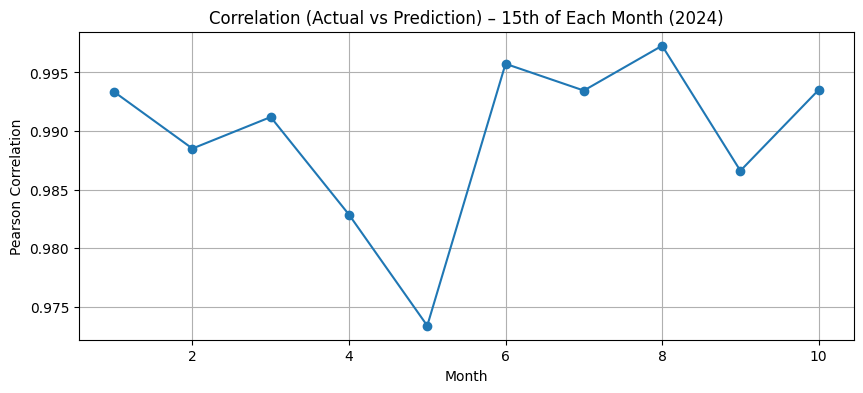

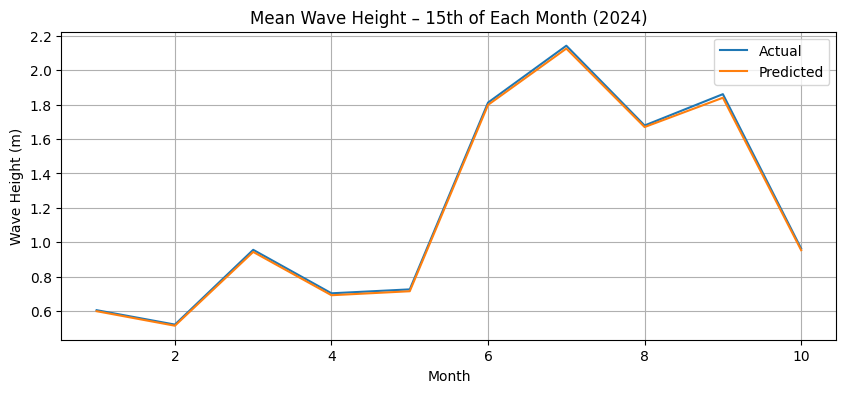

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import drive
from scipy.stats import pearsonr

# ------------------ MOUNT DRIVE ------------------
drive.mount("/content/drive")

# ------------------ PATHS ------------------
NC_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/Concatenated_Wave_Data_Bay_of_Bengal.nc"
MODEL_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_model.keras"
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"

# ------------------ LOAD DATA ------------------
ds = xr.open_dataset(NC_PATH)
model = load_model(MODEL_PATH)

lat = ds["latitude"].values
lon = ds["longitude"].values
time = pd.to_datetime(ds["valid_time"].values)

lat_idx = np.where(lat >= 17)[0]
H, W = len(lat_idx), len(lon)

sample = ds["swh"].isel(valid_time=0).values
land_mask = (np.isnan(sample) | (sample == 0))[lat_idx, :]

# ------------------ CENTROIDS ------------------
centroid_df = pd.read_csv(CENTROID_CSV)
centroid_indices = []
for _, r in centroid_df.iterrows():
    i = np.argmin(np.abs(lat - r["centroid_lat"]))
    j = np.argmin(np.abs(lon - r["centroid_lon"]))
    if i in lat_idx:
        centroid_indices.append((i, j))

# ------------------ STATS STORAGE ------------------
stats = []

# ------------------ LOOP MONTHS ------------------
for month in range(1, 13):

    day_idx = np.where(
        (time.year == 2024) &
        (time.month == month) &
        (time.day == 15)
    )[0]

    if len(day_idx) == 0:
        continue

    actual_all = []
    pred_all = []

    for t in day_idx:
        field = ds["swh"].isel(valid_time=t).values

        # Input
        X = np.zeros((H, W), dtype=np.float32)
        for (i, j) in centroid_indices:
            ii = np.where(lat_idx == i)[0][0]
            X[ii, j] = field[i, j]
        X[land_mask] = 0
        X_in = X[np.newaxis, ..., np.newaxis]

        # Prediction
        Y_pred = model.predict(X_in, verbose=0)[0, :, :, 0]
        Y_true = field[lat_idx, :]

        mask = (~np.isnan(Y_true)) & (Y_true > 0)

        actual_all.append(Y_true[mask])
        pred_all.append(Y_pred[mask])

    actual_all = np.concatenate(actual_all)
    pred_all = np.concatenate(pred_all)

    corr, _ = pearsonr(actual_all, pred_all)

    stats.append({
        "Month": month,
        "Correlation": corr,
        "Mean_Actual": np.mean(actual_all),
        "Mean_Predicted": np.mean(pred_all),
        "Mean_Bias": np.mean(pred_all - actual_all)
    })

# ------------------ RESULTS ------------------
df = pd.DataFrame(stats)
print(df)

# ------------------ PLOTS ------------------
plt.figure(figsize=(10,4))
plt.plot(df["Month"], df["Correlation"], marker="o")
plt.title("Correlation (Actual vs Prediction) – 15th of Each Month (2024)")
plt.xlabel("Month")
plt.ylabel("Pearson Correlation")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["Month"], df["Mean_Actual"], label="Actual")
plt.plot(df["Month"], df["Mean_Predicted"], label="Predicted")
plt.title("Mean Wave Height – 15th of Each Month (2024)")
plt.xlabel("Month")
plt.ylabel("Wave Height (m)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import drive


print("GPUs:", tf.config.list_physical_devices("GPU"))
mixed_precision.set_global_policy("mixed_float16")

# -------------------------------
# Mount Drive
# -------------------------------
drive.mount("/content/drive")

NC_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/Concatenated_Wave_Data_Bay_of_Bengal.nc"
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"

BEST_MODEL_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_best.keras"
LAST_MODEL_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_last.keras"

# -------------------------------
# Load dataset
# -------------------------------
ds = xr.open_dataset(NC_PATH)

WAVE_VAR = "swh"
TIME_DIM = "valid_time"

lat = ds["latitude"].values
lon = ds["longitude"].values
time = ds[TIME_DIM].values

lat_idx = np.where(lat >= 17)[0]
H = len(lat_idx)
W = len(lon)

sample = ds[WAVE_VAR].isel({TIME_DIM: 0}).values
land_mask = np.isnan(sample) | (sample == 0)
land_mask = land_mask[lat_idx, :].astype(np.float32)

# -------------------------------
# Load centroids
# -------------------------------
centroid_df = pd.read_csv(CENTROID_CSV)

centroid_indices = []
for _, row in centroid_df.iterrows():
    i = np.argmin(np.abs(lat - row["centroid_lat"]))
    j = np.argmin(np.abs(lon - row["centroid_lon"]))
    if i in lat_idx:
        centroid_indices.append((i, j))

# -------------------------------
# TIME SPLIT (UPDATED)
# -------------------------------
train_idx = np.where(time < np.datetime64("2023-01-01"))[0]            # 1984–2022
val_idx   = np.where(
    (time >= np.datetime64("2023-01-01")) &
    (time <  np.datetime64("2024-01-01"))
)[0]                                                                    # 2023
test_idx  = np.where(time >= np.datetime64("2024-01-01"))[0]            # 2024 (future use)

# -------------------------------
# Data generator
# -------------------------------
def data_generator(indices, batch_size=512):
    while True:
        np.random.shuffle(indices)
        for start in range(0, len(indices), batch_size):
            batch = indices[start:start + batch_size]
            fields = ds[WAVE_VAR].isel({TIME_DIM: batch}).values

            X = np.zeros((len(batch), H, W, 1), dtype=np.float32)
            Y = np.zeros((len(batch), H, W, 1), dtype=np.float32)

            for k in range(len(batch)):
                field = fields[k]

                y = field[lat_idx, :].copy()
                y[np.isnan(y)] = 0
                Y[k, :, :, 0] = y

                x = np.zeros((H, W), dtype=np.float32)
                for (i, j) in centroid_indices:
                    ii = np.where(lat_idx == i)[0][0]
                    x[ii, j] = field[i, j]

                x[land_mask == 1] = 0
                X[k, :, :, 0] = x

            yield X, Y

# -------------------------------
# Generators
# -------------------------------
BATCH_SIZE = 512
train_gen = data_generator(train_idx, BATCH_SIZE)
val_gen   = data_generator(val_idx,   BATCH_SIZE)

# -------------------------------
# CNN model (UNCHANGED)
# -------------------------------
def build_cnn(H, W):
    inp = layers.Input(shape=(H, W, 1))

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inp)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)

    out = layers.Conv2D(1, 1, padding="same", dtype="float32")(x)
    return models.Model(inp, out)

model = build_cnn(H, W)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

model.summary()

# -------------------------------
# CALLBACK: SAVE BEST MODEL
# -------------------------------
checkpoint = ModelCheckpoint(
    filepath=BEST_MODEL_PATH,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# -------------------------------
# TRAIN
# -------------------------------
history = model.fit(
    train_gen,
    steps_per_epoch=50,
    epochs=25,
    validation_data=val_gen,
    validation_steps=10,
    callbacks=[checkpoint]
)

# -------------------------------
# SAVE LAST EPOCH MODEL
# -------------------------------
model.save(LAST_MODEL_PATH)

print("Training complete.")
print("Best model saved at:", BEST_MODEL_PATH)
print("Last epoch model saved at:", LAST_MODEL_PATH)


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13, 33, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 13, 33, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 33, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 33, 1)      │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,993 (363.25 KB)

 Trainable params: 92,993 (363.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.3074
Epoch 1: val_loss improved from inf to 0.04939, saving model to /content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_best.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 248s 5s/step - loss: 0.3043 - val_loss: 0.0494
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0408
Epoch 2: val_loss improved from 0.04939 to 0.01547, saving model to /content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_best.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 241s 5s/step - loss: 0.0406 - val_loss: 0.0155
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0130
Epoch 3: val_loss improved from 0.01547 to 0.00589, saving model to /content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_best.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 249s 5s/step - loss: 0.0130 - val_loss: 0.0059
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0050
Epoch 4: val_loss improved from 0.00589 to 0.00263, saving model to /content/drive/MyDrive/wave height/wav

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


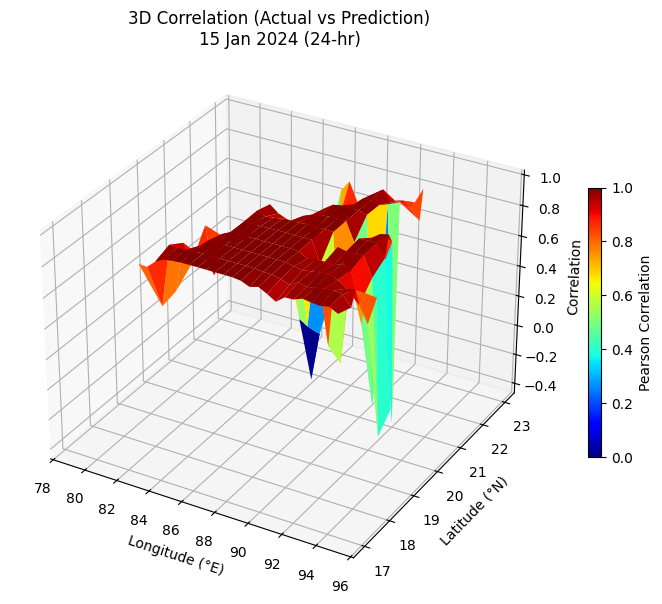

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import pearsonr
from tensorflow.keras.models import load_model
from google.colab import drive

# ------------------ MOUNT DRIVE ------------------
drive.mount("/content/drive")

# ------------------ PATHS ------------------
NC_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/Concatenated_Wave_Data_Bay_of_Bengal.nc"
MODEL_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_model.keras"
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"

# ------------------ LOAD DATA ------------------
ds = xr.open_dataset(NC_PATH)
model = load_model(MODEL_PATH)

lat = ds["latitude"].values
lon = ds["longitude"].values
time = pd.to_datetime(ds["valid_time"].values)

lat_idx = np.where(lat >= 17)[0]
H, W = len(lat_idx), len(lon)

# ------------------ LAND MASK ------------------
sample = ds["swh"].isel(valid_time=0).values
land_mask = (np.isnan(sample) | (sample == 0))[lat_idx, :]

# ------------------ CENTROIDS ------------------
centroid_df = pd.read_csv(CENTROID_CSV)
centroid_indices = []
for _, r in centroid_df.iterrows():
    i = np.argmin(np.abs(lat - r["centroid_lat"]))
    j = np.argmin(np.abs(lon - r["centroid_lon"]))
    if i in lat_idx:
        centroid_indices.append((i, j))

# ------------------ SELECT 15 JAN 2024 (24 hrs) ------------------
idx_day = np.where(
    (time.year == 2024) &
    (time.month == 1) &
    (time.day == 15)
)[0]

# ------------------ STORE TIME SERIES ------------------
actual_ts = np.zeros((H, W, len(idx_day)))
pred_ts   = np.zeros((H, W, len(idx_day)))

for t_i, t in enumerate(idx_day):
    field = ds["swh"].isel(valid_time=t).values

    # Actual
    actual = field[lat_idx, :]
    actual[np.isnan(actual)] = 0
    actual_ts[:, :, t_i] = actual

    # Sparse input
    X = np.zeros((H, W), dtype=np.float32)
    for (i, j) in centroid_indices:
        ii = np.where(lat_idx == i)[0][0]
        X[ii, j] = field[i, j]
    X[land_mask] = 0

    # Predict
    pred = model.predict(X[np.newaxis, ..., np.newaxis], verbose=0)[0, :, :, 0]
    pred_ts[:, :, t_i] = pred

# ------------------ CORRELATION PER GRID ------------------
corr_map = np.zeros((H, W))
corr_map[:] = np.nan

for i in range(H):
    for j in range(W):
        if land_mask[i, j]:
            continue
        a = actual_ts[i, j, :]
        p = pred_ts[i, j, :]
        if np.std(a) > 0 and np.std(p) > 0:
            corr_map[i, j] = pearsonr(a, p)[0]

# ------------------ 3D PLOT ------------------
Lon, Lat = np.meshgrid(lon, lat[lat_idx])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")


surf = ax.plot_surface(
    Lon, Lat, corr_map,
    cmap="jet",
    vmin=0, vmax=1,
    linewidth=0, antialiased=True
)

ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_zlabel("Correlation")
ax.set_title("3D Correlation (Actual vs Prediction)\n15 Jan 2024 (24-hr)")

fig.colorbar(surf, shrink=0.5, label="Pearson Correlation")
plt.show()



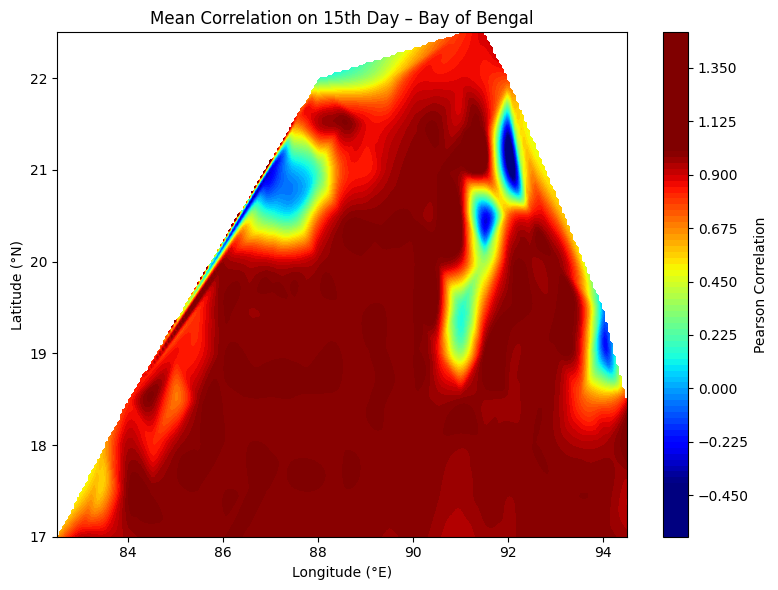

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# -----------------------------
# Prepare grids
# -----------------------------
lon_vals = lon
lat_vals = lat[lat_idx]

Lon, Lat = np.meshgrid(lon_vals, lat_vals)

# Flatten
x = Lon.flatten()
y = Lat.flatten()
z = corr_map.flatten()

mask = ~np.isnan(z)
x, y, z = x[mask], y[mask], z[mask]

# Interpolation grid
xi = np.linspace(x.min(), x.max(), 200)
yi = np.linspace(y.min(), y.max(), 200)
Xi, Yi = np.meshgrid(xi, yi)

Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# -----------------------------
# PLOT — reference style
# -----------------------------
plt.figure(figsize=(8, 6))

cf = plt.contourf(
    Xi, Yi, Zi,
    levels=100,
    cmap="jet",
    vmin=-0.4,
    vmax=1.0
)

plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
plt.title("Mean Correlation on 15th Day – Bay of Bengal")

cbar = plt.colorbar(cf)
cbar.set_label("Pearson Correlation")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os
from tensorflow.keras.models import load_model
from google.colab import drive

# ------------------ MOUNT DRIVE ------------------
drive.mount("/content/drive")

# ------------------ PATHS ------------------
NC_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/Concatenated_Wave_Data_Bay_of_Bengal.nc"
MODEL_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_model.keras"
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"
OUT_DIR = "/content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/"

# ✅ CREATE DIRECTORY
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------ LOAD DATA ------------------
ds = xr.open_dataset(NC_PATH)
model = load_model(MODEL_PATH)

lat = ds["latitude"].values
lon = ds["longitude"].values
time = pd.to_datetime(ds["valid_time"].values)

lat_idx = np.where(lat >= 17)[0]
H, W = len(lat_idx), len(lon)

sample = ds["swh"].isel(valid_time=0).values
land_mask = (np.isnan(sample) | (sample == 0))[lat_idx, :]

# ------------------ CENTROIDS ------------------
centroid_df = pd.read_csv(CENTROID_CSV)
centroid_indices = []
for _, r in centroid_df.iterrows():
    i = np.argmin(np.abs(lat - r["centroid_lat"]))
    j = np.argmin(np.abs(lon - r["centroid_lon"]))
    if i in lat_idx:
        centroid_indices.append((i, j))

# ------------------ COLOR SETTINGS ------------------
VMIN, VMAX = 0.0, 3.0
CMAP = "plasma"

# ------------------ LOOP MONTHS ------------------
for month in range(1, 13):

    print(f"Processing 2024-{month:02d}-15")

    day_idx = np.where(
        (time.year == 2024) &
        (time.month == month) &
        (time.day == 15)
    )[0]

    if len(day_idx) == 0:
        print("No data for this day")
        continue

    video_path = f"{OUT_DIR}2024_{month:02d}_15.mp4"
    writer = imageio.get_writer(video_path, fps=2)

    for t in day_idx:
        field = ds["swh"].isel(valid_time=t).values

        X = np.zeros((H, W), dtype=np.float32)
        for (i, j) in centroid_indices:
            ii = np.where(lat_idx == i)[0][0]
            X[ii, j] = field[i, j]
        X[land_mask] = 0
        X_in = X[np.newaxis, ..., np.newaxis]

        Y_pred = model.predict(X_in, verbose=0)[0, :, :, 0]
        Y_true = field[lat_idx, :]

        fig, ax = plt.subplots(1, 2, figsize=(14, 4))

        im0 = ax[0].imshow(Y_true, cmap=CMAP, vmin=VMIN, vmax=VMAX)
        ax[0].set_title("Actual (m)")
        ax[0].axis("off")
        plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

        im1 = ax[1].imshow(Y_pred, cmap=CMAP, vmin=VMIN, vmax=VMAX)
        ax[1].set_title("Prediction (m)")
        ax[1].axis("off")
        plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

        plt.suptitle(str(time[t]))
        plt.tight_layout()

        fig.canvas.draw()
        writer.append_data(np.asarray(fig.canvas.buffer_rgba()))
        plt.close(fig)

    writer.close()
    print("Saved:", video_path)

print("All monthly videos created.")


Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Processing 2024-01-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_01_15.mp4
Processing 2024-02-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_02_15.mp4
Processing 2024-03-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_03_15.mp4
Processing 2024-04-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_04_15.mp4
Processing 2024-05-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_05_15.mp4
Processing 2024-06-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_06_15.mp4
Processing 2024-07-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_07_15.mp4
Processing 2024-08-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_08_15.mp4
Processing 2024-09-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_09_15.mp4
Processing 2024-10-15


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_monthly_videos/2024_10_15.mp4
Processing 2024-11-15
No data for this day
Processing 2024-12-15
No data for this day
All monthly videos created.


In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tensorflow.keras.models import load_model
from google.colab import drive
import os

# ------------------ MOUNT DRIVE ------------------
drive.mount("/content/drive")

# ------------------ PATHS ------------------
NC_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/Concatenated_Wave_Data_Bay_of_Bengal.nc"
MODEL_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_model.keras"
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"
OUT_DIR = "/content/drive/MyDrive/wave height/wave_height_pred/2024_correlation_images"

os.makedirs(OUT_DIR, exist_ok=True)

# ------------------ LOAD DATA ------------------
ds = xr.open_dataset(NC_PATH)
model = load_model(MODEL_PATH)

lat = ds["latitude"].values
lon = ds["longitude"].values
time = pd.to_datetime(ds["valid_time"].values)

# ------------------ GRID ------------------
lat_idx = np.where(lat >= 17)[0]
lat_vals = lat[lat_idx]
lon_vals = lon

H, W = len(lat_vals), len(lon_vals)

# ------------------ LAND MASK ------------------
sample = ds["swh"].isel(valid_time=0).values
land_mask = (np.isnan(sample) | (sample == 0))[lat_idx, :]

# ------------------ CENTROIDS ------------------
centroid_df = pd.read_csv(CENTROID_CSV)
centroid_indices = []

for _, r in centroid_df.iterrows():
    i = np.argmin(np.abs(lat - r["centroid_lat"]))
    j = np.argmin(np.abs(lon - r["centroid_lon"]))
    if i in lat_idx:
        centroid_indices.append((i, j))

# ------------------ LOOP MONTHS ------------------
for month in range(1, 13):

    day_idx = np.where(
        (time.year == 2024) &
        (time.month == month) &
        (time.day == 15)
    )[0]

    if len(day_idx) < 10:
        continue

    actual_stack = []
    pred_stack = []

    for t in day_idx:
        field = ds["swh"].isel(valid_time=t).values

        # -------- Input (centroid-only) --------
        X = np.zeros((H, W), dtype=np.float32)
        for (i, j) in centroid_indices:
            ii = np.where(lat_idx == i)[0][0]
            X[ii, j] = field[i, j]
        X[land_mask] = 0
        X_in = X[np.newaxis, ..., np.newaxis]

        # -------- Prediction --------
        Y_pred = model.predict(X_in, verbose=0)[0, :, :, 0]
        Y_true = field[lat_idx, :]

        actual_stack.append(Y_true)
        pred_stack.append(Y_pred)

    actual_stack = np.stack(actual_stack)
    pred_stack = np.stack(pred_stack)

    # ------------------ CORRELATION MAP ------------------
    corr_map = np.full((H, W), np.nan)

    for i in range(H):
        for j in range(W):
            if land_mask[i, j]:
                continue
            a = actual_stack[:, i, j]
            p = pred_stack[:, i, j]
            if np.std(a) > 0 and np.std(p) > 0:
                corr_map[i, j] = pearsonr(a, p)[0]

    # ------------------ PLOT ------------------
    plt.figure(figsize=(8, 6))
    im = plt.contourf(
        lon_vals,
        lat_vals,
        corr_map,
        levels=30,
        cmap="jet",
        vmin=-1,
        vmax=1
    )
    plt.colorbar(im, label="Pearson Correlation")
    plt.xlabel("Longitude (°E)")
    plt.ylabel("Latitude (°N)")
    plt.title(f"Mean Correlation (Actual vs Prediction)\n15 {pd.to_datetime(f'2024-{month:02d}-15').strftime('%b %Y')}")
    plt.tight_layout()

    save_path = f"{OUT_DIR}/correlation_2024_{month:02d}_15.png"
    plt.savefig(save_path, dpi=300)
    plt.close()

    print("Saved:", save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_correlation_images/correlation_2024_01_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_correlation_images/correlation_2024_02_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_correlation_images/correlation_2024_03_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_correlation_images/correlation_2024_04_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_correlation_images/correlation_2024_05_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_correlation_images/correlation_2024_06_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_correlation_images/correlation_2024_07_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_correlation_images/correlation_2024_08_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_correlation_images/correlation_2024_09_15.png
Saved: /co

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import drive
import os

# ------------------ MOUNT DRIVE ------------------
drive.mount("/content/drive")

# ------------------ PATHS ------------------
NC_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/Concatenated_Wave_Data_Bay_of_Bengal.nc"
MODEL_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_best.keras"
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"

OUT_DIR = "/content/drive/MyDrive/wave height/wave_height_pred/2024_predictions"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------ LOAD DATA ------------------
ds = xr.open_dataset(NC_PATH)
model = load_model(MODEL_PATH)

lat = ds["latitude"].values
lon = ds["longitude"].values
time = pd.to_datetime(ds["valid_time"].values)

# ------------------ GRID ------------------
lat_idx = np.where(lat >= 17)[0]
lat_vals = lat[lat_idx]
lon_vals = lon
H, W = len(lat_vals), len(lon_vals)

# ------------------ LAND MASK ------------------
sample = ds["swh"].isel(valid_time=0).values
land_mask = (np.isnan(sample) | (sample == 0))[lat_idx, :]

# ------------------ CENTROIDS ------------------
centroid_df = pd.read_csv(CENTROID_CSV)
centroid_indices = []

for _, r in centroid_df.iterrows():
    i = np.argmin(np.abs(lat - r["centroid_lat"]))
    j = np.argmin(np.abs(lon - r["centroid_lon"]))
    if i in lat_idx:
        centroid_indices.append((i, j))

# ------------------ LOOP MONTHS (2024) ------------------
for month in range(1, 13):

    month_dir = f"{OUT_DIR}/{month:02d}"
    os.makedirs(month_dir, exist_ok=True)

    day_idx = np.where(
        (time.year == 2024) &
        (time.month == month) &
        (time.day == 15)
    )[0]

    print(f"Month {month}: {len(day_idx)} hours")

    for t in day_idx:
        field = ds["swh"].isel(valid_time=t).values

        # -------- Input (centroid-only) --------
        X = np.zeros((H, W), dtype=np.float32)
        for (i, j) in centroid_indices:
            ii = np.where(lat_idx == i)[0][0]
            X[ii, j] = field[i, j]
        X[land_mask] = 0
        X_in = X[np.newaxis, ..., np.newaxis]

        # -------- Prediction --------
        Y_pred = model.predict(X_in, verbose=0)[0, :, :, 0]
        Y_true = field[lat_idx, :]

        # -------- Plot --------
        fig, ax = plt.subplots(1, 2, figsize=(14, 4))

        im0 = ax[0].imshow(Y_true, cmap="viridis", vmin=0, vmax=3)
        ax[0].set_title("Actual (2024)")
        ax[0].axis("off")
        plt.colorbar(im0, ax=ax[0], fraction=0.046)

        im1 = ax[1].imshow(Y_pred, cmap="viridis", vmin=0, vmax=3)
        ax[1].set_title("Prediction (CNN)")
        ax[1].axis("off")
        plt.colorbar(im1, ax=ax[1], fraction=0.046)

        ts = time[t].strftime("%Y-%m-%d %H:%M")
        plt.suptitle(ts)
        plt.tight_layout()

        save_path = f"{month_dir}/{time[t].strftime('%Y%m%d_%H')}.png"
        plt.savefig(save_path, dpi=200)
        plt.close()

print("✅ Predictions completed for all months of 2024.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Month 1: 24 hours
Month 2: 24 hours
Month 3: 24 hours
Month 4: 24 hours
Month 5: 24 hours
Month 6: 24 hours
Month 7: 24 hours
Month 8: 24 hours
Month 9: 24 hours
Month 10: 24 hours
Month 11: 0 hours
Month 12: 0 hours
✅ Predictions completed for all months of 2024.


In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tensorflow.keras.models import load_model
from google.colab import drive
import os

# ------------------ MOUNT DRIVE ------------------
drive.mount("/content/drive")

# ------------------ PATHS (CASE-1: WITH BOUNDARY) ------------------
NC_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/Concatenated_Wave_Data_Bay_of_Bengal.nc"
MODEL_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_best.keras"   # ✅ CASE-1 MODEL
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"

OUT_DIR = "/content/drive/MyDrive/wave height/wave_height_pred/2024_correlation_images_case1"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------ LOAD DATA & MODEL ------------------
ds = xr.open_dataset(NC_PATH)
model = load_model(MODEL_PATH)

lat = ds["latitude"].values
lon = ds["longitude"].values
time = pd.to_datetime(ds["valid_time"].values)

# ------------------ GRID ------------------
lat_idx = np.where(lat >= 17)[0]
lat_vals = lat[lat_idx]
lon_vals = lon

H, W = len(lat_vals), len(lon_vals)

# ------------------ LAND MASK ------------------
sample = ds["swh"].isel(valid_time=0).values
land_mask = (np.isnan(sample) | (sample == 0))[lat_idx, :]

# ------------------ CENTROIDS (WITH BOUNDARY) ------------------
centroid_df = pd.read_csv(CENTROID_CSV)
centroid_indices = []

for _, r in centroid_df.iterrows():
    i = np.argmin(np.abs(lat - r["centroid_lat"]))
    j = np.argmin(np.abs(lon - r["centroid_lon"]))
    if i in lat_idx:
        centroid_indices.append((i, j))

# ------------------ LOOP MONTHS (2024) ------------------
for month in range(1, 13):

    day_idx = np.where(
        (time.year == 2024) &
        (time.month == month) &
        (time.day == 15)
    )[0]

    if len(day_idx) < 10:
        continue

    actual_stack = []
    pred_stack = []

    for t in day_idx:
        field = ds["swh"].isel(valid_time=t).values

        # -------- Input (centroid-only, WITH boundary) --------
        X = np.zeros((H, W), dtype=np.float32)
        for (i, j) in centroid_indices:
            ii = np.where(lat_idx == i)[0][0]
            X[ii, j] = field[i, j]

        X[land_mask] = 0
        X_in = X[np.newaxis, ..., np.newaxis]

        # -------- Prediction --------
        Y_pred = model.predict(X_in, verbose=0)[0, :, :, 0]
        Y_true = field[lat_idx, :]

        actual_stack.append(Y_true)
        pred_stack.append(Y_pred)

    actual_stack = np.stack(actual_stack)
    pred_stack = np.stack(pred_stack)

    # ------------------ CORRELATION MAP ------------------
    corr_map = np.full((H, W), np.nan)

    for i in range(H):
        for j in range(W):
            if land_mask[i, j]:
                continue

            a = actual_stack[:, i, j]
            p = pred_stack[:, i, j]

            if np.std(a) > 0 and np.std(p) > 0:
                corr_map[i, j] = pearsonr(a, p)[0]

    # ------------------ PLOT ------------------
    plt.figure(figsize=(8, 6))
    im = plt.contourf(
        lon_vals,
        lat_vals,
        corr_map,
        levels=30,
        cmap="jet",
        vmin=-1,
        vmax=1
    )
    plt.colorbar(im, label="Pearson Correlation")
    plt.xlabel("Longitude (°E)")
    plt.ylabel("Latitude (°N)")
    plt.title(
        f"Mean Correlation (Actual vs Prediction)\n"
        f"15 {pd.to_datetime(f'2024-{month:02d}-15').strftime('%b %Y')} (CASE-1)"
    )
    plt.tight_layout()

    save_path = f"{OUT_DIR}/correlation_2024_{month:02d}_15_case1.png"
    plt.savefig(save_path, dpi=300)
    plt.close()

    print("Saved:", save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_correlation_images_case1/correlation_2024_01_15_case1.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_correlation_images_case1/correlation_2024_02_15_case1.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_correlation_images_case1/correlation_2024_03_15_case1.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_correlation_images_case1/correlation_2024_04_15_case1.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_correlation_images_case1/correlation_2024_05_15_case1.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_correlation_images_case1/correlation_2024_06_15_case1.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/2024_correlation_images_case1/correlation_2024_07_15_case1.png
Saved: /content/d

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import drive

print("GPUs:", tf.config.list_physical_devices("GPU"))
mixed_precision.set_global_policy("mixed_float16")

# -------------------------------
# Mount Drive
# -------------------------------
drive.mount("/content/drive")

# -------------------------------
# PATHS
# -------------------------------
NC_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/Concatenated_Wave_Data_Bay_of_Bengal.nc"
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"

# 🔴 CLEAR CASE-2 MODEL NAMES
BEST_MODEL_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_case2_no_boundary_best_1984_2022_val2023.keras"
LAST_MODEL_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_case2_no_boundary_last_1984_2022_val2023.keras"

# -------------------------------
# Load dataset
# -------------------------------
ds = xr.open_dataset(NC_PATH)

WAVE_VAR = "swh"
TIME_DIM = "valid_time"

lat = ds["latitude"].values
lon = ds["longitude"].values
time = ds[TIME_DIM].values

# Upper-half region
lat_idx = np.where(lat >= 17)[0]
H = len(lat_idx)
W = len(lon)

# Land mask
sample = ds[WAVE_VAR].isel({TIME_DIM: 0}).values
land_mask = (np.isnan(sample) | (sample == 0))
land_mask = land_mask[lat_idx, :].astype(np.float32)

# -------------------------------
# Load centroids (CASE-2: WITHOUT BOUNDARY)
# -------------------------------
boundary_centroid_ids = [
    11, 3, 13, 10, 20, 6, 18, 2,
    7, 5, 12, 0, 23, 8, 19, 1, 14
]

centroid_df = pd.read_csv(CENTROID_CSV)

centroid_indices = []
for idx, row in centroid_df.iterrows():

    # ❌ Skip boundary centroids
    if idx in boundary_centroid_ids:
        continue

    i = np.argmin(np.abs(lat - row["centroid_lat"]))
    j = np.argmin(np.abs(lon - row["centroid_lon"]))

    if i in lat_idx:
        centroid_indices.append((i, j))

print("Centroids used (CASE-2, no boundary):", len(centroid_indices))

# -------------------------------
# TIME SPLIT
# -------------------------------
train_idx = np.where(time < np.datetime64("2023-01-01"))[0]   # 1984–2022
val_idx = np.where(
    (time >= np.datetime64("2023-01-01")) &
    (time < np.datetime64("2024-01-01"))
)[0]                                                           # 2023
test_idx = np.where(time >= np.datetime64("2024-01-01"))[0]   # 2024 (unused here)

# -------------------------------
# Data Generator
# -------------------------------
def data_generator(indices, batch_size=512):
    while True:
        np.random.shuffle(indices)
        for start in range(0, len(indices), batch_size):
            batch = indices[start:start + batch_size]
            fields = ds[WAVE_VAR].isel({TIME_DIM: batch}).values

            X = np.zeros((len(batch), H, W, 1), dtype=np.float32)
            Y = np.zeros((len(batch), H, W, 1), dtype=np.float32)

            for k in range(len(batch)):
                field = fields[k]

                # Target (full upper half)
                y = field[lat_idx, :].copy()
                y[np.isnan(y)] = 0
                Y[k, :, :, 0] = y

                # Input (centroids only, NO boundary)
                x = np.zeros((H, W), dtype=np.float32)
                for (i, j) in centroid_indices:
                    ii = np.where(lat_idx == i)[0][0]
                    x[ii, j] = field[i, j]

                x[land_mask == 1] = 0
                X[k, :, :, 0] = x

            yield X, Y

# -------------------------------
# Generators
# -------------------------------
BATCH_SIZE = 512
train_gen = data_generator(train_idx, BATCH_SIZE)
val_gen = data_generator(val_idx, BATCH_SIZE)

# -------------------------------
# CNN Model (UNCHANGED)
# -------------------------------
def build_cnn(H, W):
    inp = layers.Input(shape=(H, W, 1))

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inp)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)

    out = layers.Conv2D(1, 1, padding="same", dtype="float32")(x)
    return models.Model(inp, out)

model = build_cnn(H, W)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

model.summary()

# -------------------------------
# CALLBACK: SAVE BEST MODEL
# -------------------------------
checkpoint = ModelCheckpoint(
    filepath=BEST_MODEL_PATH,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# -------------------------------
# TRAIN (CASE-2)
# -------------------------------
history = model.fit(
    train_gen,
    steps_per_epoch=50,
    epochs=25,
    validation_data=val_gen,
    validation_steps=10,
    callbacks=[checkpoint]
)

# -------------------------------
# SAVE LAST EPOCH MODEL
# -------------------------------
model.save(LAST_MODEL_PATH)

print("✅ CASE-2 Training complete (WITHOUT boundary centroids)")
print("Best model saved at:", BEST_MODEL_PATH)
print("Last epoch model saved at:", LAST_MODEL_PATH)


GPUs: []
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Centroids used (CASE-2, no boundary): 8


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 13, 33, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 33, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 13, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 33, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 13, 33, 1)      │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,993 (363.25 KB)

 Trainable params: 92,993 (363.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 219s/step - loss: 0.4239  
Epoch 1: val_loss improved from inf to 0.08669, saving model to /content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_case2_no_boundary_best_1984_2022_val2023.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 10972s 219s/step - loss: 0.4204 - val_loss: 0.0867
Epoch 2/25
48/50 ━━━━━━━━━━━━━━━━━━━━ 7:18 219s/step - loss: 0.0763 

In [2]:
# =========================================================
# CASE-3 VIDEO: ACTUAL vs PREDICTION (15th of each month, 2024)
# Wave + Bathymetry CNN (Best Model)
# =========================================================

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from tensorflow.keras.models import load_model
from google.colab import drive
from IPython.display import Video

# ---------------------------------------------------------
# MOUNT DRIVE
# ---------------------------------------------------------
drive.mount("/content/drive")

# ---------------------------------------------------------
# PATHS
# ---------------------------------------------------------
BASE_PATH = "/content/drive/MyDrive/wave height/wave_height_pred"

WAVE_NC   = f"{BASE_PATH}/Concatenated_Wave_Data_Bay_of_Bengal.nc"
BATHY_NC  = f"{BASE_PATH}/Bathymetry_Bay_Bengal.nc"
MODEL_PATH = f"{BASE_PATH}/wave_cnn_CASE3_wave_bathymetry_best.keras"
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"

VIDEO_PATH = f"{BASE_PATH}/CASE3_2024_monthly15_actual_vs_pred.mp4"

# ---------------------------------------------------------
# LOAD DATA & MODEL
# ---------------------------------------------------------
wave_ds  = xr.open_dataset(WAVE_NC)
bathy_ds = xr.open_dataset(BATHY_NC)
model = load_model(MODEL_PATH)

WAVE_VAR = "swh"
TIME_DIM = "valid_time"

lat  = wave_ds["latitude"].values
lon  = wave_ds["longitude"].values
time = pd.to_datetime(wave_ds[TIME_DIM].values)

# ---------------------------------------------------------
# REGION: UPPER HALF (>=17°N)
# ---------------------------------------------------------
lat_idx = np.where(lat >= 17)[0]
H, W = len(lat_idx), len(lon)

# ---------------------------------------------------------
# LAND MASK
# ---------------------------------------------------------
sample = wave_ds[WAVE_VAR].isel({TIME_DIM: 0}).values
land_mask = (np.isnan(sample) | (sample == 0))[lat_idx, :]

# ---------------------------------------------------------
# LOAD & FIX BATHYMETRY
# ---------------------------------------------------------
bathy_var = list(bathy_ds.data_vars)[0]
bathy_raw = bathy_ds[bathy_var]

if bathy_raw.ndim == 3:
    bathy_raw = bathy_raw.isel({bathy_raw.dims[0]: 0})

bathy = bathy_raw.values
bathy = bathy[lat_idx, :]
bathy = np.where(land_mask, 0, bathy)

# ---------------------------------------------------------
# LOAD SCALERS (SAME VALUES USED DURING TRAINING)
# ---------------------------------------------------------
wave_min, wave_max = 0.040945973, 12.537901
bathy_min, bathy_max = 5.0, 999.0

def scale_to_minus1_1(x, xmin, xmax):
    return 2.0 * (x - xmin) / (xmax - xmin + 1e-6) - 1.0

def inverse_scale(x, xmin, xmax):
    return (x + 1.0) * 0.5 * (xmax - xmin) + xmin

# Scale bathymetry once
bathy_scaled = scale_to_minus1_1(bathy, bathy_min, bathy_max)
bathy_scaled[land_mask] = 0

# ---------------------------------------------------------
# LOAD CENTROIDS (CASE-2 STYLE: NO BOUNDARY)
# ---------------------------------------------------------
boundary_centroid_ids = [
    11, 3, 13, 10, 20, 6, 18, 2,
    7, 5, 12, 0, 23, 8, 19, 1, 14
]

centroid_df = pd.read_csv(CENTROID_CSV)
centroid_indices = []

for idx, r in centroid_df.iterrows():
    if idx in boundary_centroid_ids:
        continue
    i = np.argmin(np.abs(lat - r["centroid_lat"]))
    j = np.argmin(np.abs(lon - r["centroid_lon"]))
    if i in lat_idx:
        centroid_indices.append((i, j))

print("Centroids used (CASE-3):", len(centroid_indices))

# ---------------------------------------------------------
# SELECT 15th OF EACH MONTH (2024)
# ---------------------------------------------------------
month_days = []
for m in range(1, 13):
    idx = np.where(
        (time.year == 2024) &
        (time.month == m) &
        (time.day == 15)
    )[0]
    month_days.extend(idx)

print("Total frames:", len(month_days))

# ---------------------------------------------------------
# VIDEO WRITER (2 FPS = 0.5s per frame)
# ---------------------------------------------------------
writer = imageio.get_writer(VIDEO_PATH, fps=2)

# ---------------------------------------------------------
# CREATE VIDEO
# ---------------------------------------------------------
for n, t in enumerate(month_days):

    field = wave_ds[WAVE_VAR].isel({TIME_DIM: t}).values

    # -------- INPUT (2 CHANNELS) --------
    x_wave = np.zeros((H, W), dtype=np.float32)
    for (i, j) in centroid_indices:
        ii = np.where(lat_idx == i)[0][0]
        val = field[i, j]
        if not np.isnan(val):
            x_wave[ii, j] = scale_to_minus1_1(val, wave_min, wave_max)

    x_wave[land_mask] = 0

    X = np.zeros((1, H, W, 2), dtype=np.float32)
    X[0, :, :, 0] = x_wave
    X[0, :, :, 1] = bathy_scaled

    # -------- PREDICTION --------
    y_pred_scaled = model.predict(X, verbose=0)[0, :, :, 0]
    y_pred = inverse_scale(y_pred_scaled, wave_min, wave_max)

    # -------- ACTUAL --------
    y_true = field[lat_idx, :]

    # -------- PLOT --------
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    im0 = ax[0].imshow(y_true, cmap="viridis", vmin=0, vmax=3)
    ax[0].set_title("Actual Wave Height (m)")
    ax[0].axis("off")
    plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(y_pred, cmap="viridis", vmin=0, vmax=3)
    ax[1].set_title("CASE-3 Prediction (m)")
    ax[1].axis("off")
    plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    plt.suptitle(f"15 {time[t].strftime('%b %Y')}")
    plt.tight_layout()

    fig.canvas.draw()
    writer.append_data(np.asarray(fig.canvas.buffer_rgba()))
    plt.close(fig)

    print(f"Processed {n+1}/{len(month_days)}")

writer.close()

print("🎬 CASE-3 video saved at:", VIDEO_PATH)
Video(VIDEO_PATH, embed=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
Exception ignored in: <function CachingFileManager.__del__ at 0x7be710f651c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/xarray/backends/file_manager.py", line 258, in __del__
    self.close(needs_lock=False)
  File "/usr/local/lib/python3.12/dist-packages/xarray/backends/file_manager.py", line 242, in close
    file.close()
  File "/usr/local/lib/python3.12/dist-packages/h5netcdf/core.py", line 1846, in close
    self._h5file.close()
  File "/usr/local/lib/python3.12/dist-packages/h5py/_hl/files.py", line 632, in close
    self.id._close_open_objects(h5f.OBJ_LOCAL | h5f.OBJ_FILE)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx",

Centroids used (CASE-3): 8
Total frames: 240
Processed 1/240
Processed 2/240
Processed 3/240
Processed 4/240
Processed 5/240
Processed 6/240
Processed 7/240
Processed 8/240
Processed 9/240
Processed 10/240
Processed 11/240
Processed 12/240
Processed 13/240
Processed 14/240
Processed 15/240
Processed 16/240
Processed 17/240
Processed 18/240
Processed 19/240
Processed 20/240
Processed 21/240
Processed 22/240
Processed 23/240
Processed 24/240
Processed 25/240
Processed 26/240
Processed 27/240
Processed 28/240
Processed 29/240
Processed 30/240
Processed 31/240
Processed 32/240
Processed 33/240
Processed 34/240
Processed 35/240
Processed 36/240
Processed 37/240
Processed 38/240
Processed 39/240
Processed 40/240
Processed 41/240
Processed 42/240
Processed 43/240
Processed 44/240
Processed 45/240
Processed 46/240
Processed 47/240
Processed 48/240
Processed 49/240
Processed 50/240
Processed 51/240
Processed 52/240
Processed 53/240
Processed 54/240
Processed 55/240
Processed 56/240
Processed 57

In [3]:
# =========================================================
# CASE-3: MONTH-WISE VIDEOS (15th of each month, 2024)
# =========================================================

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from tensorflow.keras.models import load_model
from google.colab import drive
import os

# ------------------ MOUNT DRIVE ------------------
drive.mount("/content/drive")

# ------------------ PATHS ------------------
BASE_PATH = "/content/drive/MyDrive/wave height/wave_height_pred"

WAVE_NC   = f"{BASE_PATH}/Concatenated_Wave_Data_Bay_of_Bengal.nc"
BATHY_NC  = f"{BASE_PATH}/Bathymetry_Bay_Bengal.nc"
MODEL_PATH = f"{BASE_PATH}/wave_cnn_CASE3_wave_bathymetry_best.keras"
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"

OUT_DIR = f"{BASE_PATH}/CASE3_2024_monthly_videos"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------ LOAD DATA & MODEL ------------------
wave_ds  = xr.open_dataset(WAVE_NC)
bathy_ds = xr.open_dataset(BATHY_NC)
model = load_model(MODEL_PATH)

lat  = wave_ds["latitude"].values
lon  = wave_ds["longitude"].values
time = pd.to_datetime(wave_ds["valid_time"].values)

# ------------------ REGION ------------------
lat_idx = np.where(lat >= 17)[0]
H, W = len(lat_idx), len(lon)

# ------------------ LAND MASK ------------------
sample = wave_ds["swh"].isel(valid_time=0).values
land_mask = (np.isnan(sample) | (sample == 0))[lat_idx, :]

# ------------------ LOAD BATHYMETRY ------------------
bathy_var = list(bathy_ds.data_vars)[0]
bathy_raw = bathy_ds[bathy_var]

if bathy_raw.ndim == 3:
    bathy_raw = bathy_raw.isel({bathy_raw.dims[0]: 0})

bathy = bathy_raw.values
bathy = bathy[lat_idx, :]
bathy = np.where(land_mask, 0, bathy)

# ------------------ SCALERS (FROM TRAINING) ------------------
wave_min, wave_max = 0.040945973, 12.537901
bathy_min, bathy_max = 5.0, 999.0

def scale(x, xmin, xmax):
    return 2 * (x - xmin) / (xmax - xmin + 1e-6) - 1

def inverse_scale(x, xmin, xmax):
    return (x + 1) * 0.5 * (xmax - xmin) + xmin

bathy_scaled = scale(bathy, bathy_min, bathy_max)
bathy_scaled[land_mask] = 0

# ------------------ LOAD CENTROIDS (NO BOUNDARY) ------------------
boundary_ids = [11,3,13,10,20,6,18,2,7,5,12,0,23,8,19,1,14]

centroid_df = pd.read_csv(CENTROID_CSV)
centroid_indices = []

for idx, r in centroid_df.iterrows():
    if idx in boundary_ids:
        continue
    i = np.argmin(np.abs(lat - r["centroid_lat"]))
    j = np.argmin(np.abs(lon - r["centroid_lon"]))
    if i in lat_idx:
        centroid_indices.append((i, j))

print("Centroids used:", len(centroid_indices))

# ------------------ VISUAL SETTINGS ------------------
VMIN, VMAX = 0, 3
CMAP = "viridis"   # clean & smooth
FPS = 2            # 0.5 sec per frame

# ------------------ LOOP MONTHS ------------------
for month in range(1, 13):

    idxs = np.where(
        (time.year == 2024) &
        (time.month == month) &
        (time.day == 15)
    )[0]

    if len(idxs) == 0:
        continue

    video_path = f"{OUT_DIR}/CASE3_2024_{month:02d}_15.mp4"
    writer = imageio.get_writer(video_path, fps=FPS)

    for t in idxs:
        field = wave_ds["swh"].isel(valid_time=t).values

        # -------- INPUT --------
        x_wave = np.zeros((H, W), dtype=np.float32)
        for (i, j) in centroid_indices:
            ii = np.where(lat_idx == i)[0][0]
            val = field[i, j]
            if not np.isnan(val):
                x_wave[ii, j] = scale(val, wave_min, wave_max)

        x_wave[land_mask] = 0

        X = np.zeros((1, H, W, 2), dtype=np.float32)
        X[0, :, :, 0] = x_wave
        X[0, :, :, 1] = bathy_scaled

        # -------- PREDICTION --------
        y_pred = model.predict(X, verbose=0)[0, :, :, 0]
        y_pred = inverse_scale(y_pred, wave_min, wave_max)

        y_true = field[lat_idx, :]

        # -------- PLOT --------
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))

        im0 = ax[0].imshow(y_true, cmap=CMAP, vmin=VMIN, vmax=VMAX)
        ax[0].set_title("Actual Wave Height (m)")
        ax[0].axis("off")

        im1 = ax[1].imshow(y_pred, cmap=CMAP, vmin=VMIN, vmax=VMAX)
        ax[1].set_title("CASE-3 Prediction (m)")
        ax[1].axis("off")

        plt.suptitle(time[t].strftime("15 %b %Y  %H:%M UTC"))
        plt.tight_layout()

        fig.canvas.draw()
        writer.append_data(np.asarray(fig.canvas.buffer_rgba()))
        plt.close(fig)

    writer.close()
    print("Saved:", video_path)

print("✅ All month-wise CASE-3 videos generated.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Centroids used: 8
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_monthly_videos/CASE3_2024_01_15.mp4
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_monthly_videos/CASE3_2024_02_15.mp4
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_monthly_videos/CASE3_2024_03_15.mp4
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_monthly_videos/CASE3_2024_04_15.mp4
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_monthly_videos/CASE3_2024_05_15.mp4
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_monthly_videos/CASE3_2024_06_15.mp4
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_monthly_videos/CASE3_2024_07_15.mp4
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_monthly_videos/CASE3_2024_08_15.mp4
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_monthly_videos/CASE3_2024_09_15.mp4
Saved: /content/drive/MyDriv

In [1]:
 # =========================================================
# CASE-3 CORRELATION MAPS (15th of each month, 2024)
# Mean Pearson Correlation | Actual vs Prediction
# =========================================================

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tensorflow.keras.models import load_model
from google.colab import drive
import os

# ------------------ MOUNT DRIVE ------------------
drive.mount("/content/drive")

# ------------------ PATHS ------------------
BASE_PATH = "/content/drive/MyDrive/wave height/wave_height_pred"

WAVE_NC   = f"{BASE_PATH}/Concatenated_Wave_Data_Bay_of_Bengal.nc"
BATHY_NC  = f"{BASE_PATH}/Bathymetry_Bay_Bengal.nc"
MODEL_PATH = f"{BASE_PATH}/wave_cnn_CASE3_wave_bathymetry_best.keras"
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"

OUT_DIR = f"{BASE_PATH}/CASE3_2024_correlation_maps"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------ LOAD DATA & MODEL ------------------
wave_ds  = xr.open_dataset(WAVE_NC)
bathy_ds = xr.open_dataset(BATHY_NC)
model = load_model(MODEL_PATH)

lat  = wave_ds["latitude"].values
lon  = wave_ds["longitude"].values
time = pd.to_datetime(wave_ds["valid_time"].values)

# ------------------ REGION ------------------
lat_idx = np.where(lat >= 17)[0]
lat_vals = lat[lat_idx]
lon_vals = lon
H, W = len(lat_vals), len(lon_vals)

# ------------------ LAND MASK ------------------
sample = wave_ds["swh"].isel(valid_time=0).values
land_mask = (np.isnan(sample) | (sample == 0))[lat_idx, :]

# ------------------ LOAD & FIX BATHYMETRY ------------------
bathy_var = list(bathy_ds.data_vars)[0]
bathy_raw = bathy_ds[bathy_var]

if bathy_raw.ndim == 3:
    bathy_raw = bathy_raw.isel({bathy_raw.dims[0]: 0})

bathy = bathy_raw.values
bathy = bathy[lat_idx, :]
bathy = np.where(land_mask, 0, bathy)

# ------------------ SCALERS (FROM TRAINING) ------------------
wave_min, wave_max = 0.040945973, 12.537901
bathy_min, bathy_max = 5.0, 999.0

def scale(x, xmin, xmax):
    return 2 * (x - xmin) / (xmax - xmin + 1e-6) - 1

def inverse_scale(x, xmin, xmax):
    return (x + 1) * 0.5 * (xmax - xmin) + xmin

bathy_scaled = scale(bathy, bathy_min, bathy_max)
bathy_scaled[land_mask] = 0

# ------------------ LOAD CENTROIDS (NO BOUNDARY) ------------------
boundary_ids = [11,3,13,10,20,6,18,2,7,5,12,0,23,8,19,1,14]

centroid_df = pd.read_csv(CENTROID_CSV)
centroid_indices = []

for idx, r in centroid_df.iterrows():
    if idx in boundary_ids:
        continue
    i = np.argmin(np.abs(lat - r["centroid_lat"]))
    j = np.argmin(np.abs(lon - r["centroid_lon"]))
    if i in lat_idx:
        centroid_indices.append((i, j))

print("Centroids used (CASE-3):", len(centroid_indices))

# ------------------ LOOP MONTHS ------------------
for month in range(1, 13):

    idxs = np.where(
        (time.year == 2024) &
        (time.month == month) &
        (time.day == 15)
    )[0]

    if len(idxs) < 10:
        continue

    actual_stack = []
    pred_stack = []

    for t in idxs:
        field = wave_ds["swh"].isel(valid_time=t).values

        # -------- INPUT --------
        x_wave = np.zeros((H, W), dtype=np.float32)
        for (i, j) in centroid_indices:
            ii = np.where(lat_idx == i)[0][0]
            val = field[i, j]
            if not np.isnan(val):
                x_wave[ii, j] = scale(val, wave_min, wave_max)

        x_wave[land_mask] = 0

        X = np.zeros((1, H, W, 2), dtype=np.float32)
        X[0, :, :, 0] = x_wave
        X[0, :, :, 1] = bathy_scaled

        # -------- PREDICTION --------
        y_pred = model.predict(X, verbose=0)[0, :, :, 0]
        y_pred = inverse_scale(y_pred, wave_min, wave_max)

        y_true = field[lat_idx, :]

        actual_stack.append(y_true)
        pred_stack.append(y_pred)

    actual_stack = np.stack(actual_stack)
    pred_stack = np.stack(pred_stack)

    # ------------------ CORRELATION MAP ------------------
    corr_map = np.full((H, W), np.nan)

    for i in range(H):
        for j in range(W):
            if land_mask[i, j]:
                continue

            a = actual_stack[:, i, j]
            p = pred_stack[:, i, j]

            if np.std(a) > 0 and np.std(p) > 0:
                corr_map[i, j] = pearsonr(a, p)[0]

    # ------------------ PLOT (CORRECT ORIENTATION) ------------------
    plt.figure(figsize=(8, 6))
    im = plt.contourf(
        lon_vals,
        lat_vals,
        corr_map,
        levels=30,
        cmap="jet",
        vmin=-1,
        vmax=1
    )
    plt.colorbar(im, label="Pearson Correlation")
    plt.xlabel("Longitude (°E)")
    plt.ylabel("Latitude (°N)")
    plt.title(
        f"CASE-3 Mean Correlation (Actual vs Prediction)\n"
        f"15 {pd.to_datetime(f'2024-{month:02d}-15').strftime('%b %Y')}"
    )
    plt.tight_layout()

    save_path = f"{OUT_DIR}/CASE3_corr_2024_{month:02d}_15.png"
    plt.savefig(save_path, dpi=300)
    plt.close()

    print("Saved:", save_path)

print("✅ CASE-3 correlation maps generated.")


Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Centroids used (CASE-3): 8


/tmp/ipython-input-537187024.py:144: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_map[i, j] = pearsonr(a, p)[0]


Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_correlation_maps/CASE3_corr_2024_01_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_correlation_maps/CASE3_corr_2024_02_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_correlation_maps/CASE3_corr_2024_03_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_correlation_maps/CASE3_corr_2024_04_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_correlation_maps/CASE3_corr_2024_05_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_correlation_maps/CASE3_corr_2024_06_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_correlation_maps/CASE3_corr_2024_07_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_correlation_maps/CASE3_corr_2024_08_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_correlation_maps/CASE3_cor

In [2]:
# =========================================================
# CASE-3: MEAN CORRELATION MAPS (15th of each month, 2024)
# Fixed colorbar range for ALL plots
# =========================================================

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tensorflow.keras.models import load_model
from google.colab import drive
import os

# ------------------ MOUNT DRIVE ------------------
drive.mount("/content/drive")

# ------------------ PATHS ------------------
BASE_PATH = "/content/drive/MyDrive/wave height/wave_height_pred"

WAVE_NC   = f"{BASE_PATH}/Concatenated_Wave_Data_Bay_of_Bengal.nc"
BATHY_NC  = f"{BASE_PATH}/Bathymetry_Bay_Bengal.nc"
MODEL_PATH = f"{BASE_PATH}/wave_cnn_CASE3_wave_bathymetry_best.keras"
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"

OUT_DIR = f"{BASE_PATH}/CASE3_2024_correlation_maps_fixed"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------ LOAD DATA & MODEL ------------------
wave_ds  = xr.open_dataset(WAVE_NC)
bathy_ds = xr.open_dataset(BATHY_NC)
model = load_model(MODEL_PATH)

lat  = wave_ds["latitude"].values
lon  = wave_ds["longitude"].values
time = pd.to_datetime(wave_ds["valid_time"].values)

# ------------------ REGION (>=17°N) ------------------
lat_idx = np.where(lat >= 17)[0]
lat_vals = lat[lat_idx]
lon_vals = lon
H, W = len(lat_vals), len(lon_vals)

# ------------------ LAND MASK ------------------
sample = wave_ds["swh"].isel(valid_time=0).values
land_mask = (np.isnan(sample) | (sample == 0))[lat_idx, :]

# ------------------ LOAD & FIX BATHYMETRY ------------------
bathy_var = list(bathy_ds.data_vars)[0]
bathy_raw = bathy_ds[bathy_var]

if bathy_raw.ndim == 3:
    bathy_raw = bathy_raw.isel({bathy_raw.dims[0]: 0})

bathy = bathy_raw.values
bathy = bathy[lat_idx, :]
bathy = np.where(land_mask, 0, bathy)

# ------------------ SCALERS (FROM TRAINING) ------------------
wave_min, wave_max = 0.040945973, 12.537901
bathy_min, bathy_max = 5.0, 999.0

def scale(x, xmin, xmax):
    return 2 * (x - xmin) / (xmax - xmin + 1e-6) - 1

def inverse_scale(x, xmin, xmax):
    return (x + 1) * 0.5 * (xmax - xmin) + xmin

bathy_scaled = scale(bathy, bathy_min, bathy_max)
bathy_scaled[land_mask] = 0

# ------------------ LOAD CENTROIDS (NO BOUNDARY) ------------------
boundary_ids = [11,3,13,10,20,6,18,2,7,5,12,0,23,8,19,1,14]

centroid_df = pd.read_csv(CENTROID_CSV)
centroid_indices = []

for idx, r in centroid_df.iterrows():
    if idx in boundary_ids:
        continue
    i = np.argmin(np.abs(lat - r["centroid_lat"]))
    j = np.argmin(np.abs(lon - r["centroid_lon"]))
    if i in lat_idx:
        centroid_indices.append((i, j))

print("Centroids used (CASE-3):", len(centroid_indices))

# ------------------ FIXED COLORBAR SETTINGS ------------------
CORR_VMIN = -1.0
CORR_VMAX =  1.0
CORR_LEVELS = np.linspace(CORR_VMIN, CORR_VMAX, 21)

# ------------------ LOOP MONTHS ------------------
for month in range(1, 13):

    idxs = np.where(
        (time.year == 2024) &
        (time.month == month) &
        (time.day == 15)
    )[0]

    if len(idxs) < 10:
        continue

    actual_stack = []
    pred_stack = []

    for t in idxs:
        field = wave_ds["swh"].isel(valid_time=t).values

        # -------- INPUT --------
        x_wave = np.zeros((H, W), dtype=np.float32)
        for (i, j) in centroid_indices:
            ii = np.where(lat_idx == i)[0][0]
            val = field[i, j]
            if not np.isnan(val):
                x_wave[ii, j] = scale(val, wave_min, wave_max)

        x_wave[land_mask] = 0

        X = np.zeros((1, H, W, 2), dtype=np.float32)
        X[0, :, :, 0] = x_wave
        X[0, :, :, 1] = bathy_scaled

        # -------- PREDICTION --------
        y_pred = model.predict(X, verbose=0)[0, :, :, 0]
        y_pred = inverse_scale(y_pred, wave_min, wave_max)

        y_true = field[lat_idx, :]

        actual_stack.append(y_true)
        pred_stack.append(y_pred)

    actual_stack = np.stack(actual_stack)
    pred_stack = np.stack(pred_stack)

    # ------------------ CORRELATION MAP ------------------
    corr_map = np.full((H, W), np.nan)

    for i in range(H):
        for j in range(W):
            if land_mask[i, j]:
                continue
            a = actual_stack[:, i, j]
            p = pred_stack[:, i, j]
            if np.std(a) > 0 and np.std(p) > 0:
                corr_map[i, j] = pearsonr(a, p)[0]

    # ------------------ PLOT ------------------
    plt.figure(figsize=(8, 6))
    im = plt.contourf(
        lon_vals,
        lat_vals,
        corr_map,
        levels=CORR_LEVELS,
        cmap="jet",
        vmin=CORR_VMIN,
        vmax=CORR_VMAX
    )

    cbar = plt.colorbar(im)
    cbar.set_label("Pearson Correlation")

    plt.xlabel("Longitude (°E)")
    plt.ylabel("Latitude (°N)")
    plt.title(
        f"CASE-3 Mean Correlation (Actual vs Prediction)\n"
        f"15 {pd.to_datetime(f'2024-{month:02d}-15').strftime('%b %Y')}"
    )

    plt.tight_layout()
    save_path = f"{OUT_DIR}/CASE3_corr_2024_{month:02d}_15.png"
    plt.savefig(save_path, dpi=300)
    plt.close()

    print("Saved:", save_path)

print("✅ CASE-3 fixed-range correlation maps generated.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Centroids used (CASE-3): 8


/tmp/ipython-input-1248177652.py:147: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_map[i, j] = pearsonr(a, p)[0]


Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_correlation_maps_fixed/CASE3_corr_2024_01_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_correlation_maps_fixed/CASE3_corr_2024_02_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_correlation_maps_fixed/CASE3_corr_2024_03_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_correlation_maps_fixed/CASE3_corr_2024_04_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_correlation_maps_fixed/CASE3_corr_2024_05_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_correlation_maps_fixed/CASE3_corr_2024_06_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_correlation_maps_fixed/CASE3_corr_2024_07_15.png
Saved: /content/drive/MyDrive/wave height/wave_height_pred/CASE3_2024_correlation_maps_fixed/CASE3_corr_2024_08_15.png
Saved: /content/drive/MyDrive/wave height/wave_h

In [1]:
# =========================================================
# CASE-1: HOURLY VIDEO (ACTUAL vs PREDICTION)
# DATE: 15 JULY 2024
# =========================================================

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from tensorflow.keras.models import load_model
from google.colab import drive
from IPython.display import Video

# ------------------ MOUNT DRIVE ------------------
drive.mount("/content/drive")

# ------------------ PATHS (CASE-1 MODEL) ------------------
NC_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/Concatenated_Wave_Data_Bay_of_Bengal.nc"
MODEL_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/wave_cnn_best.keras"  # CASE-1 model
CENTROID_CSV = "/content/drive/MyDrive/wave height/Wave_Monthly_Plots/centroids_upper_25.csv"

VIDEO_PATH = "/content/drive/MyDrive/wave height/wave_height_pred/case1_15July2024_actual_vs_pred.mp4"

# ------------------ LOAD DATA & MODEL ------------------
ds = xr.open_dataset(NC_PATH)
model = load_model(MODEL_PATH)

lat = ds["latitude"].values
lon = ds["longitude"].values
time = pd.to_datetime(ds["valid_time"].values)

# ------------------ SELECT 15 JULY 2024 ------------------
day_idx = np.where(
    (time.year == 2024) &
    (time.month == 7) &
    (time.day == 15)
)[0]

print("Total hours on 15 July 2024:", len(day_idx))

# ------------------ GRID (UPPER HALF) ------------------
lat_idx = np.where(lat >= 17)[0]
H, W = len(lat_idx), len(lon)

# ------------------ LAND MASK ------------------
sample = ds["swh"].isel(valid_time=0).values
land_mask = (np.isnan(sample) | (sample == 0))[lat_idx, :]

# ------------------ LOAD CENTROIDS (CASE-1: WITH BOUNDARY) ------------------
centroid_df = pd.read_csv(CENTROID_CSV)

centroid_indices = []
for _, r in centroid_df.iterrows():
    i = np.argmin(np.abs(lat - r["centroid_lat"]))
    j = np.argmin(np.abs(lon - r["centroid_lon"]))
    if i in lat_idx:
        centroid_indices.append((i, j))

print("Centroids used:", len(centroid_indices))

# ------------------ VIDEO WRITER ------------------
writer = imageio.get_writer(VIDEO_PATH, fps=2)  # 0.5 sec per frame

VMIN, VMAX = 0, 3  # fixed color range for clarity

# ------------------ CREATE FRAMES ------------------
for t in day_idx:

    field = ds["swh"].isel(valid_time=t).values

    # ---- INPUT (SPARSE CENTROIDS) ----
    X = np.zeros((H, W), dtype=np.float32)
    for (i, j) in centroid_indices:
        ii = np.where(lat_idx == i)[0][0]
        X[ii, j] = field[i, j]

    X[land_mask] = 0
    X_in = X[np.newaxis, ..., np.newaxis]

    # ---- PREDICTION ----
    Y_pred = model.predict(X_in, verbose=0)[0, :, :, 0]
    Y_true = field[lat_idx, :]

    # ---- PLOT ----
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    im0 = axes[0].imshow(Y_true, cmap="plasma", vmin=VMIN, vmax=VMAX)
    axes[0].set_title("Actual Wave Height (m)")
    axes[0].axis("off")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(Y_pred, cmap="plasma", vmin=VMIN, vmax=VMAX)
    axes[1].set_title("CNN Prediction – Case 1")
    axes[1].axis("off")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    plt.suptitle(str(time[t]))
    plt.tight_layout()

    fig.canvas.draw()
    writer.append_data(np.asarray(fig.canvas.buffer_rgba()))
    plt.close(fig)

writer.close()

print("✅ Video saved at:", VIDEO_PATH)

# ------------------ DISPLAY VIDEO ------------------
Video(VIDEO_PATH, embed=True)


Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Total hours on 15 July 2024: 24
Centroids used: 25


✅ Video saved at: /content/drive/MyDrive/wave height/wave_height_pred/case1_15July2024_actual_vs_pred.mp4
